In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
plt.style.use('seaborn')



def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
    eVal=np.linspace(eMin,eMax,pts)
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    pdf=pd.Series(pdf.flatten(),index=eVal.flatten())
    return pdf

def getPCA(matrix):
    # Get eVal,eVec from a Hermitian matrix
    eVal,eVec=np.linalg.eigh(matrix)
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices]
    eVal=np.diagflat(eVal)
    return eVal,eVec

def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape)==1:
        obs=obs.reshape(-1,1)
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs)
    if x is None:
        x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:
        x=x.reshape(-1,1)
    logProb=kde.score_samples(x) # log(density)
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf

"""
 FITTING
 THE
 MARCENKO–PASTUR PDF
"""
from scipy.optimize import minimize
def errPDFs(var,eVal,q,bWidth,pts=1000):
    # Fit error
    pdf0=mpPDF(var,q,pts) # theoretical pdf
    pdf1=fitKDE(eVal,bWidth,x=pdf0.index.values) # empirical pdf
    sse=np.sum((pdf1-pdf0)**2)
    return sse

def findMaxEval(eVal,q,bWidth):
    # Find max random eVal by fitting Marcenko’s dist
    out=minimize(lambda *x: errPDFs(*x), .5 , args=(eVal,q,bWidth),
                    bounds=((1E-5,1-1E-5),)
                )
    if out['success']:
        var=out['x'][0]
    else:
        var=1
    eMax=var*(1+(1./q)**.5)**2
    return eMax, var

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr

### Import new CC data

In [107]:
result = pd.read_csv('~/Works/practicum_github_repo/Crypto-Data/matrix_shaped_data.csv')

In [108]:
result = result.set_index('close_time')

In [109]:
result = result[(result.index >= '2019-01-01')]
# result = result[(result.index >= '2019-01-01')]

In [110]:
result = result.loc[:, ~result.columns.isin(['usdtusd'])]

In [115]:
returns = result.pct_change().iloc[1:, :].copy()
returns.dropna(axis = 1, thresh=len(returns.index)/2, inplace=True) # Drop stocks with over half the data missing
# returns.dropna(axis = 0, thresh=len(returns.columns), inplace=True) # Drop days without data for all stocks

In [116]:
returns

,antusd,btcusd,dashusd,dgbusd,eosusd,ethusd,funusd,iotausd,kmdusd,lskusd,...,scusd,sntusd,trxusd,vetusd,xlmusd,xmrusd,xvgusd,zecusd,zenusd,zrxusd
close_time,,,,,,,,,,,,,,,,,,,,,
2019-01-02,NaN,0.037812,0.059387,-0.017177,0.041914,0.172440,0.025844,0.042347,NaN,0.082707,...,0.000000,0.013054,0.616163,0.049148,0.043242,0.054457,0.040541,0.330799,NaN,0.414288
2019-01-03,NaN,0.030556,0.065011,0.008138,0.084632,-0.036242,0.128359,0.067765,NaN,-0.076389,...,0.000000,0.047831,0.017539,0.016905,0.026895,0.083466,0.049377,0.029795,NaN,0.045946
2019-01-04,-1.000000,-0.021439,-0.012124,0.030545,-0.073732,-0.012415,-0.098471,-0.036653,NaN,-1.000000,...,0.000000,-0.018098,-0.006620,-0.054275,-0.052881,-0.054621,-0.063083,-0.044989,NaN,-0.020333
2019-01-05,NaN,0.011326,0.291892,-0.010236,0.016978,0.039345,0.084258,-0.009105,NaN,NaN,...,0.000000,0.004649,0.088459,0.028792,0.016516,0.020082,0.005566,0.005770,NaN,0.006465
2019-01-06,NaN,0.003004,0.004946,0.033273,-0.012297,0.004314,-0.055140,-0.024041,NaN,-1.000000,...,0.000000,0.057216,0.129690,-0.011304,-0.017049,-0.019853,0.005958,-0.013558,NaN,-0.003618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-15,-0.112411,0.039959,0.162587,-0.008052,0.036402,0.020771,0.106557,0.081072,-0.009141,-0.035980,...,-0.009346,-0.045973,0.010305,0.021472,-0.005317,0.003155,0.090303,0.007755,-0.023386,-0.016340
2020-05-16,-0.163576,-0.042228,-0.044248,-0.022003,-0.016904,-0.044338,-0.040741,-0.059927,-0.028745,0.040488,...,-0.056604,-0.043614,-0.021065,0.010015,-0.049933,-0.041928,0.063193,-0.031711,-0.011830,0.111636
2020-05-17,0.046509,0.007320,0.028985,-0.032850,0.020807,0.029196,0.015444,0.004994,0.037176,-0.057071,...,0.005000,-0.029870,0.006110,0.019329,0.032366,0.042980,-0.111444,0.014244,-0.010192,0.008537


In [143]:
list(returns.columns)

['antusd',
 'btcusd',
 'dashusd',
 'dgbusd',
 'eosusd',
 'ethusd',
 'funusd',
 'iotausd',
 'kmdusd',
 'lskusd',
 'manausd',
 'mgousd',
 'miotausd',
 'neousd',
 'omgusd',
 'qtumusd',
 'repusd',
 'scusd',
 'sntusd',
 'trxusd',
 'vetusd',
 'xlmusd',
 'xmrusd',
 'xvgusd',
 'zecusd',
 'zenusd',
 'zrxusd']

In [117]:
training_period = 100
in_sample = returns.iloc[:(returns.shape[0]-training_period), :].copy()

In [118]:
tickers = returns.columns

In [119]:
pd.set_option('use_inf_as_na', True)
in_sample_log_returns = np.log(1+in_sample)
# log_returns.dropna(0, inplace= True)
# log_returns.dropna(1, inplace= True)

<ipython-input-119-727b27cd2217>:2: RuntimeWarning: divide by zero encountered in log
  in_sample_log_returns = np.log(1+in_sample)


In [120]:
# We will need the standard deviations later:
variances = np.diag(in_sample_log_returns.cov().values)
standard_deviations = np.sqrt(variances) 

In [121]:
corr_mat = in_sample_log_returns.interpolate().corr()

In [122]:
"""
Start with CCs correlation matrix 
"""
eVal0,eVec0=getPCA(corr_mat)

In [123]:
q = returns.shape[0]/corr_mat.shape[0]

In [124]:
# get bulk of Evalue and Variance
eMax0, var0=findMaxEval(np.diag(eVal0), q, bWidth=.01)
# get nFacts
nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)

In [125]:
nFacts0

1

In [126]:
var0

0.99999

In [127]:
eMax0

1.5164663136429195

In [128]:
D, S = np.linalg.eigh(corr_mat)

print(D[D > eMax0])

[9.1598761]


In [129]:
len(D)

27

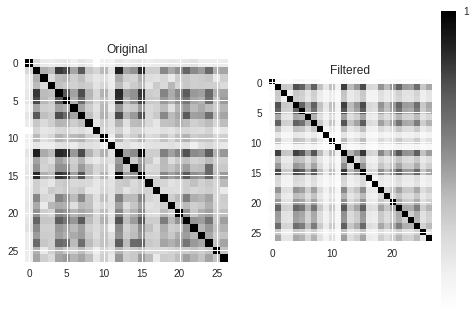

In [130]:
# Filter the eigenvalues out
D[D <= eMax0] = 0

# Reconstruct the matrix
temp =  np.dot(S, np.dot(np.diag(D), np.transpose(S)))

# Set the diagonal entries to 0
np.fill_diagonal(temp, 1)
filtered_matrix = temp

f = plt.figure()
ax = plt.subplot(121)
ax.imshow(corr_mat)
plt.title("Original")
ax = plt.subplot(122)
plt.title("Filtered")
a = ax.imshow(filtered_matrix)
cbar = f.colorbar(a, ticks=[-1, 0, 1])

In [131]:
nFacts0

1

In [132]:
"""
 SNIPPET 2.5 DENOISING
 BY
 CONSTANT RESIDUAL EIGENVALUE
"""
def denoisedCorr(eVal,eVec,nFacts):
    # Remove noise from corr by fixing random eigenvalues
    eVal_=np.diag(eVal).copy()
    eVal_[nFacts:]=eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts)
    eVal_=np.diag(eVal_)
    corr1=np.dot(eVec,eVal_).dot(eVec.T)
    corr1=cov2corr(corr1)
    return corr1

# get denoised correlation matrix
corr1=denoisedCorr(eVal0,eVec0,nFacts0)
eVal1,eVec1=getPCA(corr1)

In [133]:
eVal2,eVec2=getPCA(filtered_matrix)

In [134]:
findMaxEval(np.diag(eVec1), q, bWidth=.01)

(1.5164663136429195, 0.99999)

In [135]:
findMaxEval(np.diag(eVec2), q, bWidth=.01)

(1.5164663136429195, 0.99999)

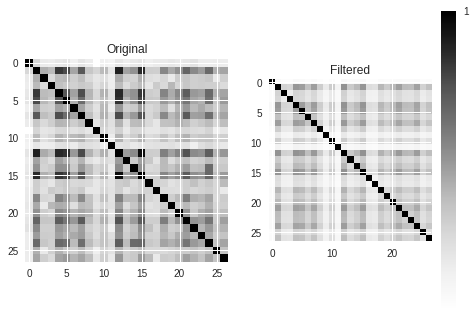

In [136]:
f = plt.figure()
ax = plt.subplot(121)
ax.imshow(corr_mat)
plt.title("Original")
ax = plt.subplot(122)
plt.title("Filtered")
a = ax.imshow(corr1)
cbar = f.colorbar(a, ticks=[-1, 0, 1])

In [137]:
in_sample

,antusd,btcusd,dashusd,dgbusd,eosusd,ethusd,funusd,iotausd,kmdusd,lskusd,...,scusd,sntusd,trxusd,vetusd,xlmusd,xmrusd,xvgusd,zecusd,zenusd,zrxusd
close_time,,,,,,,,,,,,,,,,,,,,,
2019-01-02,NaN,0.037812,0.059387,-0.017177,0.041914,0.172440,0.025844,0.042347,NaN,0.082707,...,0.000000,0.013054,0.616163,0.049148,0.043242,0.054457,0.040541,0.330799,NaN,0.414288
2019-01-03,NaN,0.030556,0.065011,0.008138,0.084632,-0.036242,0.128359,0.067765,NaN,-0.076389,...,0.000000,0.047831,0.017539,0.016905,0.026895,0.083466,0.049377,0.029795,NaN,0.045946
2019-01-04,-1.000000,-0.021439,-0.012124,0.030545,-0.073732,-0.012415,-0.098471,-0.036653,NaN,-1.000000,...,0.000000,-0.018098,-0.006620,-0.054275,-0.052881,-0.054621,-0.063083,-0.044989,NaN,-0.020333
2019-01-05,NaN,0.011326,0.291892,-0.010236,0.016978,0.039345,0.084258,-0.009105,NaN,NaN,...,0.000000,0.004649,0.088459,0.028792,0.016516,0.020082,0.005566,0.005770,NaN,0.006465
2019-01-06,NaN,0.003004,0.004946,0.033273,-0.012297,0.004314,-0.055140,-0.024041,NaN,-1.000000,...,0.000000,0.057216,0.129690,-0.011304,-0.017049,-0.019853,0.005958,-0.013558,NaN,-0.003618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-05,-0.038119,-0.012369,-0.001256,0.029450,0.003132,-0.000376,0.102041,0.001214,0.030030,0.171332,...,0.109375,-0.015044,0.003646,0.003382,0.040266,-0.023329,0.091487,-0.020534,0.007580,0.071846
2020-02-06,0.091064,0.055963,0.084842,0.109077,0.071952,0.084385,-0.033951,-0.012122,0.046603,0.095103,...,-0.037559,0.116653,0.069075,0.015895,0.045282,0.034794,-0.009416,0.099300,0.006140,-0.032010
2020-02-07,0.061650,0.016977,-0.096912,-0.001693,0.012006,0.049615,0.086230,0.003196,0.062718,-0.006625,...,0.060976,0.022136,0.095029,0.116156,0.048404,0.005676,0.009178,-0.010467,0.055697,0.139033


         Investment Weight
btcusd            0.549720
iotausd           0.169615
zenusd            0.123101
mgousd            0.093491
sntusd            0.072087


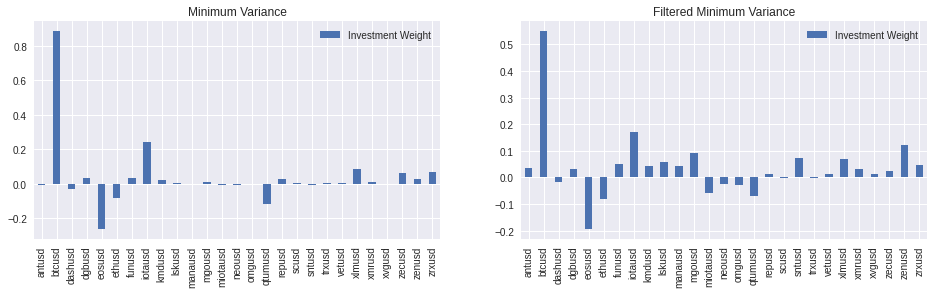

In [139]:
# Reconstruct the filtered covariance matrix
covariance_matrix = in_sample.cov()
inv_cov_mat = np.linalg.pinv(covariance_matrix)

# Construct minimum variance weights
ones = np.ones(len(inv_cov_mat))
inv_dot_ones = np.dot(inv_cov_mat, ones)
min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)

plt.figure(figsize=(16,4))

ax = plt.subplot(121)
min_var_portfolio = pd.DataFrame(data= min_var_weights, 
                                 columns = ['Investment Weight'],
                                 index = tickers)
min_var_portfolio.plot(kind = 'bar', ax = ax)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.title('Minimum Variance')

# Reconstruct the filtered covariance matrix from the standard deviations and the filtered correlation matrix
filtered_cov = np.dot(np.diag(standard_deviations), 
                           np.dot(filtered_matrix,np.diag(standard_deviations)))

filt_inv_cov = np.linalg.pinv(filtered_cov)

# Construct minimum variance weights
ones = np.ones(len(filt_inv_cov))
inv_dot_ones = np.dot(filt_inv_cov, ones)
filt_min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)
ax = plt.subplot(122)
filt_min_var_portfolio = pd.DataFrame(data= filt_min_var_weights, 
                                 columns = ['Investment Weight'],
                                 index = tickers)
filt_min_var_portfolio.plot(kind = 'bar', ax = ax)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.title('Filtered Minimum Variance')

print(filt_min_var_portfolio.sort_values(by='Investment Weight', ascending=False).head())

Text(0.5, 1.0, 'Filtered (Blue) vs. Normal (Black)')

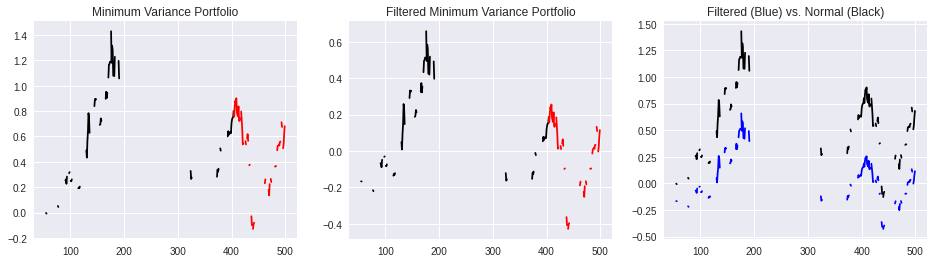

In [140]:
def get_cumulative_returns_over_time(sample, weights):
    # Ignoring short sales
    weights[weights <= 0 ] = 0 
    weights = weights / weights.sum()
    return (((1+sample).cumprod(axis=0))-1).dot(weights)

in_sample_ind = np.arange(0, (returns.shape[0]-training_period+1))
out_sample_ind = np.arange((returns.shape[0]-training_period), returns.shape[0])

cumulative_returns = get_cumulative_returns_over_time(returns, min_var_portfolio).values
cumulative_returns_filt = get_cumulative_returns_over_time(returns, filt_min_var_portfolio).values

f = plt.figure(figsize=(16,4))

ax = plt.subplot(131)
ax.plot(cumulative_returns[in_sample_ind], 'black')
ax.plot(out_sample_ind,cumulative_returns[out_sample_ind], 'r')
plt.title("Minimum Variance Portfolio")

ax = plt.subplot(132)
ax.plot(cumulative_returns_filt[in_sample_ind], 'black')
ax.plot(out_sample_ind,cumulative_returns_filt[out_sample_ind], 'r')
plt.title("Filtered Minimum Variance Portfolio")

ax = plt.subplot(133)
ax.plot(cumulative_returns, 'black')
ax.plot(cumulative_returns_filt, 'b')
plt.title("Filtered (Blue) vs. Normal (Black)")

          Investment Weight
btcusd             0.295364
zecusd             0.155198
miotausd           0.140110
qtumusd            0.140104
mgousd             0.125378


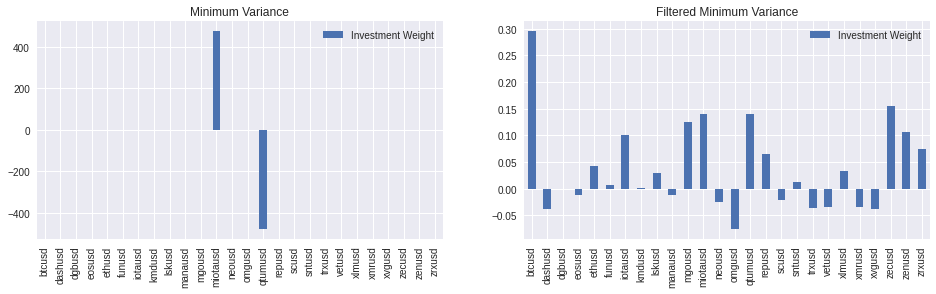

In [337]:
# Reconstruct the filtered covariance matrix
covariance_matrix = returns.cov()
inv_cov_mat = np.linalg.pinv(covariance_matrix)

# Construct minimum variance weights
ones = np.ones(len(inv_cov_mat))
inv_dot_ones = np.dot(inv_cov_mat, ones)
min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)

plt.figure(figsize=(16,4))

ax = plt.subplot(121)
min_var_portfolio = pd.DataFrame(data= min_var_weights, 
                                 columns = ['Investment Weight'],
                                 index = tickers)
min_var_portfolio.plot(kind = 'bar', ax = ax)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.title('Minimum Variance')

# Reconstruct the filtered covariance matrix from the standard deviations and the filtered correlation matrix
filtered_cov = np.dot(np.diag(standard_deviations), 
                           np.dot(corr1,np.diag(standard_deviations)))

filt_inv_cov = np.linalg.pinv(filtered_cov)

# Construct minimum variance weights
ones = np.ones(len(filt_inv_cov))
inv_dot_ones = np.dot(filt_inv_cov, ones)
filt_min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)
ax = plt.subplot(122)
filt_min_var_portfolio = pd.DataFrame(data= filt_min_var_weights, 
                                 columns = ['Investment Weight'],
                                 index = tickers)
filt_min_var_portfolio.plot(kind = 'bar', ax = ax)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.title('Filtered Minimum Variance')

print(filt_min_var_portfolio.sort_values(by='Investment Weight', ascending=False).head())

In [338]:
filt_min_var_portfolio.sort_values(by='Investment Weight', ascending=False)

,Investment Weight
btcusd,0.295364
zecusd,0.155198
miotausd,0.140110
qtumusd,0.140104
mgousd,0.125378
zenusd,0.105607
iotausd,0.100883
zrxusd,0.074942
repusd,0.065050
ethusd,0.041671
